# Lab2: 模型的剪枝稀疏

# 在开始之前


> 提示：为防止各种意外情况，请大家常按<kbd>Ctrl</kbd>+<kbd>s</kbd>对文档进行保存。

> 提示：在继续前，请切换至正确的内核。
> - 如果使用我们的整合包，请切换到`EST1601`内核
> - 如果使用交我算平台，请切换到`torch_2.0.1`或`chatglm*`内核

在Lab1中，我们动手训练出了的图像分类模型。然而，现在的模型通常包含数百万甚至数十亿的参数，存储这些参数需要大量的内存和磁盘空间，以至于很难在资源受限的设备（如移动设备、嵌入式系统）上运行。

**模型的剪枝稀疏是一种有效减少参数量的方法**。现有研究表明，模型当中的有些参数没什么用，所以可以去掉，不用存储、不用计算。从神经网络的角度，剪枝稀疏即删掉一些突触和神经元；从参数矩阵的角度，剪枝稀疏即将权重矩阵中的部分元素置为0。

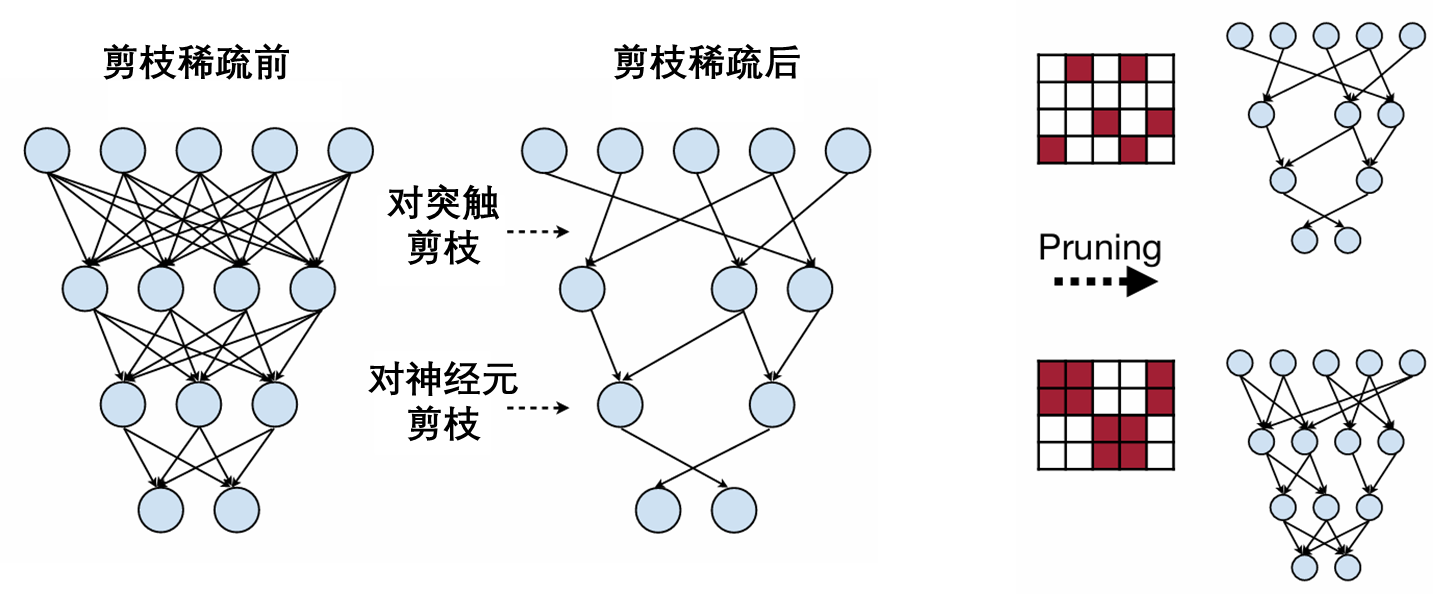

尽管理论上而言，数字0不用存储，也不用计算（0*任何数=0, 0+任何数=数字本身），但若要在真实场景中通过稀疏获得收益，往往需要软硬件的协同设计--稀疏模式、稀疏编码、硬件计算单元...缺一不可。因此，**本次实验侧重于算法上的模拟**。

## 注意事项

**本次实验是实验课大作业的组成部分，请认真对待。有可能需要写报告，所以在做完试验后，请保存好包含执行结果的文档，方便写报告时使用。**

**本次实验代码相关任务采用自动化评分。由于我们采用特定的注释来定位，因此，如果看到类似于`# ABC1234`这样的注释，请不要修改，以避免带来不必要的麻烦`>_<`**

**本次实验有一些问题，需要同学们作答。提交方式暂未确定，同学们可以先回答到文档中。我们在文档中预留了一些类似于`> WCdMbdx2RC`的文本，以方便我们定位同学们的回答，请不要修改**。**请注意：对于本次实验中的问题，水太多字会被扣分；简明扼要、准确无误、清楚明白的给出你的见解即可。**

## 准备工作

我们还是像Lab1开始一样，导入必要的包，完成初始化操作。

**以下代码块无需理解，但在每块代码前添加了注释，方便同学大致了解代码的作用**

In [ ]:
# 导入一些必要的包

import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader

from torchvision.datasets import *
from torchvision.transforms import *



# 判断是否有卡用
if torch.cuda.is_available(): # CUDA(英伟达系列GPU)
	my_device = "cuda"
elif torch.backends.mps.is_available(): # 苹果M系列芯片
	my_device = "mps"
else:
	my_device = "cpu"

In [ ]:
# 初始化随机数种子
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
# 一个从指定地址下载文件的函数，本次实验中用于从网络上下载已训练好的模型参数
# p.s. 事实上，常用的包(如Transformers)已经封装好了下载模型参数的函数--甚至你只要传入模型名字，就能够直接把模型下载下来！

def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

下面的代码熟悉吗`: )`

In [ ]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

下面还是我们在Lab1中所实现的`train`函数，用于完整的遍历一次数据集（亦即：调用一次`train`函数，即进行一轮Epoch）。由于采用了Mini-Batch的随机梯度下降，所以每次前向-反向过程只会用到一部分数据（1个Batch）

> 不过，本次实验中**有一些新操作，需要在每次前向-反向传播后，都执行一下**。
>
> 或许你会想到：复制一份`train`函数，修改函数名为`train_new`；然后直接将新操作相关代码直接添加到`for`循环内部末尾就好了...吗?
> 
> 这样倒是能跑啦，但似乎**不够优雅**。
> 1. 如果我有不同的需求，是否对于每个需求，我都要复制一个新的`train`函数？
> 2. 这些复制出的`train`函数，只有最后的操作是不同的，中间的前向-反向代码完全相同--**相同的逻辑被复制了多次**
> 3. (承接第二点)这就意味着，如果要修改前向-反向代码，你需要对所有复制出的`train`函数进行修改
>
> 所以，相较于Lab1的`train`函数，我们增加了`callbacks`（回调，字面意思就是，干完事了，回来调用一下）这一参数（要么为`None`，要么传入一个列表，列表中的每一个元素都是函数，即我们在每轮前向-反向传播后要执行的新操作），并在`for`循环的末尾对`callbacks`这个列表进行遍历，执行其中的函数。

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  """对模型进行一个epoch的训练
    
    Args:
        model: 待训练的神经网络模型
        dataloader: 提供训练数据批次的数据加载器
        criterion: 用于计算损失的损失函数模块
        optimizer: 参数优化器
        scheduler: 学习率调度器，每个批次后更新
        callbacks: 可选的回调函数列表，每个批次后按顺序执行
    
"""
  model.train()

  for inputs, targets in dataloader:
    # 移动数据到合适的设备上
    inputs = inputs.to(my_device)
    targets = targets.to(my_device)

    # 清空梯度
    optimizer.zero_grad()

    # 前向传播
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # 反向传播求梯度
    loss.backward()

    # 让优化器根据梯度等信息更新参数；更新学习率
    optimizer.step()
    scheduler.step()

    # 添加了回调函数
    if callbacks is not None:
        for callback in callbacks:
            callback()

下面也是我们在Lab1当中定义过的，一个只做推理(前向过程)的**评估函数**，能够遍历测试集，并返回准确率。

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in dataloader:
    # Move the data from CPU to GPU
    inputs = inputs.to(my_device)
    targets = targets.to(my_device)

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

在本次实验当中会用到的**助手函数**(Helpler Function)。所谓助手函数，是将常用的操作封装成一个函数，不用每次都写很长的代码了。

**以下代码需要理解含义，但无需填充**

In [ ]:
def get_sparsity(tensor: torch.Tensor) -> float:
    """
    计算给定张量的稀疏度
        稀疏度 = 张量中0的数目 / 张量中的总元素数目 = 1 - 张量中非0的数目 / 张量中的总元素数目
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    计算给定模型的稀疏度
        稀疏度 = 模型中0的数目 / 模型中的总元素数目 = 1 - 模型中非0的数目 / 模型中的总元素数目
    """
    num_nonzeros, num_elements = 0, 0 # 初始化非零元素计数器和总元素计数器
    for param in model.parameters(): # 遍历模型的所有参数张量；通过nn.Module.parameters()方法获取模块中的所有参数（我们在Lab0.2优化器部分见过哦）
        num_nonzeros += param.count_nonzero() # 累加当前参数张量中的非零元素数量
        num_elements += param.numel() # 累加当前参数张量的总元素数量
    return 1 - float(num_nonzeros) / num_elements # 计算稀疏度

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    计算模型的参数总量
    :param count_nonzero_only: 只统计非0参数
    """
    num_counted_elements = 0  # 初始化计数器，用于记录需要统计的元素数量
    for param in model.parameters(): # 遍历模型的所有参数张量
        if count_nonzero_only: # 如果仅统计非零元素
            num_counted_elements += param.count_nonzero() # 累加当前参数张量中的非零元素数量
        else: # 否则统计所有元素
            num_counted_elements += param.numel()  # 累加当前参数张量的总元素数量
    return num_counted_elements # 返回统计的元素总数


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    计算模型参数需占用的存储空间(单位: bit)
    :param data_width: 每个参数数值的数据位宽
    :param count_nonzero_only: 是否仅统计非0值
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte # 咦？为啥这里的KB之间夹了个`i`呢？等价的问题：为什么我买的1TB硬盘，插到电脑上显示只有~930GB？
MiB = 1024 * KiB
GiB = 1024 * MiB

下方定义了若干**测试函数及测试用例**，大家可以通过它们检验自己相关实现是否正确，后面会用到。

> **测试**其实是软件开发中必不可少的环节，甚至有“测试开发岗”(测开)这样的岗位，专注于测试开发岗同学写出的代码。但我们自己平时...哎，没事随手测一下，其实也挺好？不用都写完了，才发觉有Bug，彼时再定位可能就麻烦咯...

**以下代码无需理解，知道用于测试即可**

In [ ]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title): # 绘制2D张量格子图，并把数值飙上去
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel() # 展平
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    目标稀疏度: {target_sparsity:.2f}')
    print(f'        剪枝前的稀疏度: {sparsity_before_pruning:.2f}')
    print(f'        剪枝后的稀疏度: {sparsity_after_pruning:.2f}')
    print(f'        掩码的稀疏度: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* 测试通过')
        else:
            print('* 测试失败')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* 测试通过')
        else:
            print('* 测试失败')

**以下代码无需理解，知道用于下载模型参数、加载模型参数即可**。在本次实验中，大家统一使用我们训练好的模型参数，以确保公平。

> `model = VGG()`实例化了`VGG`类，同时也初始化了模块(模型)所包含的参数。
> 此时，其中的参数并非是训练好的；需要借助`load_state_dict`方法，将我们模型参数文件中的参数，读进模型。

In [ ]:
checkpoint_url = "https://est1601-resource.881222.xyz/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().to(my_device)
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

准备一下`CIFAR10`数据集，我们在Lab1中较为详细的阐述了相关内容，不再过多赘述。

> 不妨简单回忆一下：
> 1. `transforms`词典针对训练集和测试集定义了不同的预处理过程
> 2. 经过预处理后的、原始的训练集、测试集数据集被加载到`dataset`词典中
> 3. 使用`DataLoader`的目的是为了把若干单条数据拼成Batch，以便后续Mini-Batch随机梯度下降的训练过程使用

In [ ]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=256,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

## 稠密模型的准确率和模型大小

在进行稀疏实验之前，我们首先来看一下稠密（未经剪枝稀疏）模型的准确性和模型大小。

In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

虽然大型神经网络非常强大，但其也会消耗大量存储、内存带宽和计算资源。正如我们从上面的结果中看到的那样，对于将 $32\times32$ 的图像分为 10 个类别这样简单的任务，一个模型的大小可以达到 35 MiB。对于嵌入式移动应用来说，这些资源需求是非常大的，难以运行。

幸运的是，我们可以通过神经网络剪枝稀疏技术，减少模型的存储和传输需求。

剪枝的目的是在**保持准确性的同时**，**减小模型的大小**。

# 权重参数的分布

在开始剪枝之前，我们先来看看稠密模型中，权重值的分布情况。

**以下代码无需理解，知道用于绘制模型中不同模块参数的分布直方图(Histogram, 缩写Hist)即可**

> 直方图就像一个个“小柱子”组成的图形，每个柱子的高度代表数据的数量，下面有一个统计身高的直方图（x轴实为身高）。横轴（x轴）表示数据的区间（比如：165cm~170cm/170~175cm/...），纵轴（y轴）表示每个区间内数据的频数（比如有多少人）。例如：身高处于160~165cm的同学大概有250位。

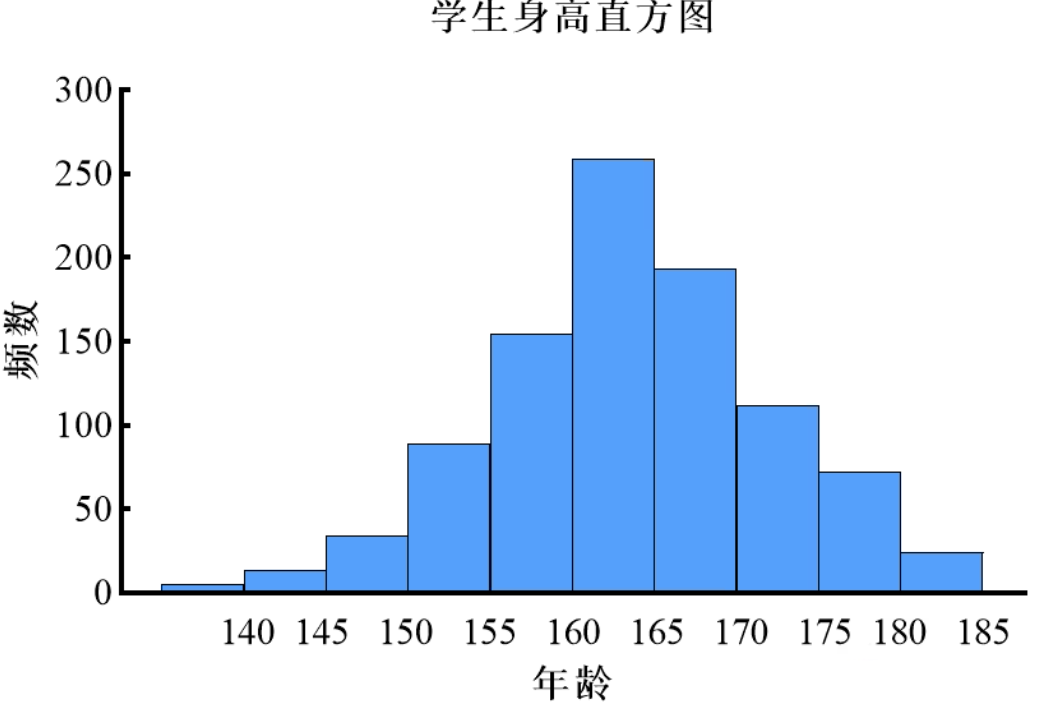

> 那么下方代码绘制的直方图，横轴是参数的数值，每个柱子统计了某个范围内有多少参数（例如：模块所有参数中，有多少位于0.1~0.2/0.2~0.3/0.3~0.4之间呢？）（注：为方便举例，区间长度用了0.1，但实际是多少，由画图库自己决定）

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters(): # 通过遍历model.named_parameters操作权重...
        if param.dim() > 1: 
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5) # Hist ==> Histogram
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5) # Hist ==> Histogram
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925) # 调到顶端的距离 https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
    plt.show()

plot_weight_distribution(model)

## 问题1

请根据上述权重柱状图中的信息回答下列问题。

1. 各层权重分布的共同特点是什么？
2. 这些特点对剪枝稀疏有什么帮助？

> WCdMbdx2RC

**答:** 【请在此处回答问题，不要答在上下两行`> WCdMbdx2RC`之外】

> WCdMbdx2RC

# 细粒度剪枝

接下来，我们将实现并进行细粒度(具体说来，是逐元素(Per-Element)粒度的)剪枝。

细粒度剪枝会删除重要性最低的突触(a.k.a. 会把权重张量中“不重要”的数字置为0)。经过精细剪枝后，权重张量$W$将变得稀疏（a.k.a. 其中有很多0）。有多稀疏？可用**稀疏度**来描述：

$$\mathrm{稀疏度} := \frac{\mathrm{0的数目}}{\mathrm{总元素数}} = 1 - \frac{\mathrm{非0的数目}}{\mathrm{总元素数}}$$

那么，怎么做细粒度稀疏呢？以下是一种大思路：

1. 对权重张量中**每个元素**进行**打分**(a.k.a. 获取每个元素的**重要性**) 
2. 根据**得分(重要性)**和**目标稀疏度**，**决定哪些元素要被剪枝掉**(a.k.a. **不重要的会被置为0**) 
3. 根据第2步的决定，**实施剪枝**

那么，怎么实现代码呢？以下是一种思路：

1. **根据选择的打分标准，对权重张量使用*逐元素*操作，进行打分，得到分数(重要性, Importance)张量**。（因为是逐元素的，所以每个元素都有一个分数，且分数张量的形状和权重张量的形状相同）
2. （假设分数越高越重要）**根据分数和目标稀疏度，得到一个分数“阈值”（threshold, 缩写thr/th/t）；如果某元素的分数小于该阈值，则被剪枝掉**
    - 可以先对所有分数进行排序，然后挑出第`稀疏度 * 元素数目`大的分数作为阈值
    - 然后，使用`权重张量 > 阈值`得到一个布尔张量(张量中每个元素要么为`True`，要么为`False`)，我们称之为**二进制掩码$M$**(**M**ask)。由于比较大小也是逐元素操作，所以也会得到和权重张量的形状相同的布尔张量。如果布尔张量中某元素为`False`，意味着这个元素的得分小于阈值，会被剪枝掉
3. 将权重张量 $W$ 与二进制掩码 $M$ 做逐元素相乘，就得到了稀疏后的权重

**上述过程的示意图如下：**

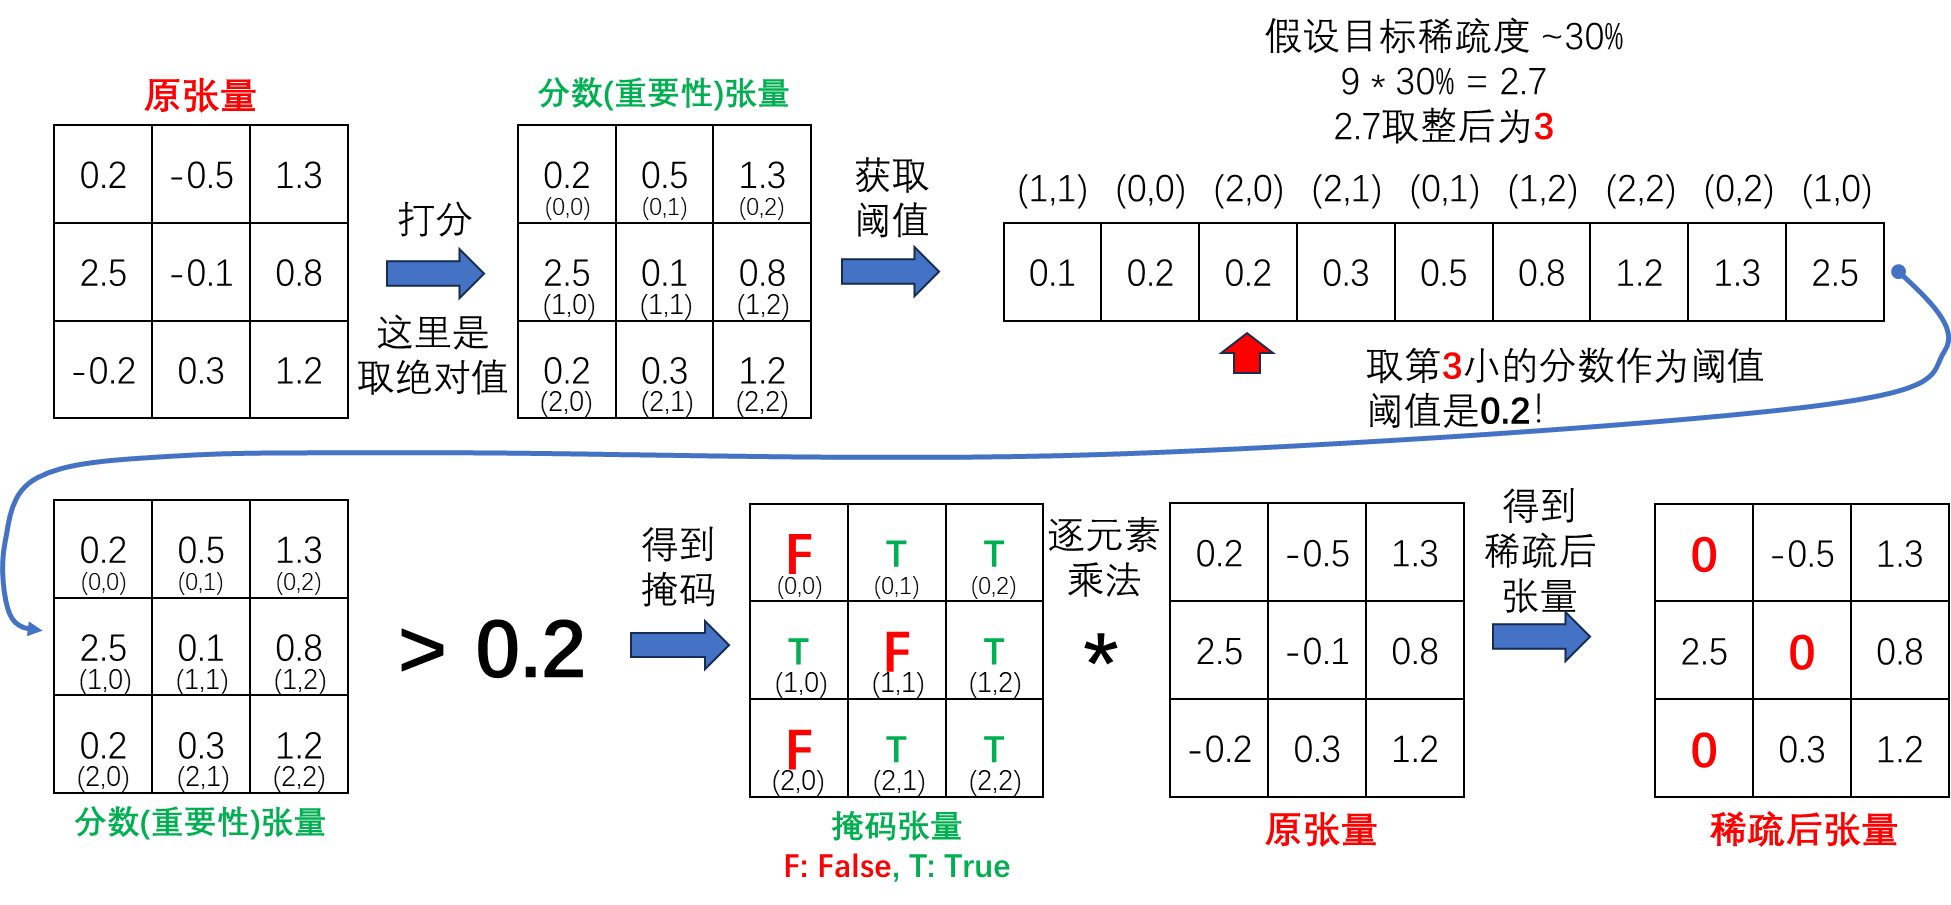

**上述过程的伪代码如下：**

> 注：
> - $\texttt{getscore}$ 能够基于打分标准，对给定张量中每个元素进行打分，返回一个和权重张量的形状相同的分数张量
> - $Importance$ 是与 $W$ 形状相同的分数(重要性)张量（$W$中每个元素的分数(重要性)）
> - $\texttt{kthvalue}(X, k)$ 函数能够求出张量$X$的第k个最小值
> - $v_{\mathrm{thr}}$ 是分数阈值

$$Importance=\texttt{getscore}(W)$$

$$v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$$

$$M = Importance > v_{\mathrm{thr}}$$

$$W = W \cdot M$$



## 基于数值大小进行剪枝稀疏

对于细粒度剪枝，一种广泛使用的打分标准是：采用绝对值大小作为分数：

> `abs`: 绝对值，**Abs**olute Value

$$Importance=abs(W)$$

### 代码任务1

接下来，请你完成基于数值大小进行剪枝稀疏的函数

> 提示：
> 1. **在第1步，我们为权重张量中每个元素进行打分(评估重要性)**。由于我们选定的打分标准是绝对值，所以你可以用Pytorch提供的[`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs)、[`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs)、[`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) 等方法来对张量求逐元素的绝对值
> 2. **在第2步，我们获取阈值**。如果某元素得分小于阈值，则会被置为0。在PyTorch中，可通过如下方法求张量中第k大的数字：[`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html)、[`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html)、[`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html)等
> 3. **在第3步，我们根据阈值计算剪枝掩码。掩码中的`True`表示保留，掩码中的`False`表示将对应元素置为0**。`掩码 = 重要性 > 阈值`。
> 4. **在第4步，将掩码应用到原权重张量上，得到剪枝稀疏后的张量**

**以下代码需要理解含义，也需要填充**

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    对单个张量进行基于数值大小的修剪
    :param tensor: torch中的Tensor, 线性层/卷积层的权重
    :param sparsity: float, 目标稀疏度
        稀疏度 = 张量中0的数目 / 张量中的总元素数目 = 1 - 张量中非0的数目 / 张量中的总元素数目
    :return:
        torch.(cuda.)Tensor, 返回掩码；掩码中的True(1)代表保留相应元素；False(0)代表对相应元素执行剪枝(置为0)
    """
    sparsity = min(max(0.0, sparsity), 1.0) # 确保稀疏度在[0, 1]之间
    # 处理一些边界情况
    if sparsity == 1.0: # 稀疏度为1：全裁掉
        tensor.zero_()
        return torch.zeros_like(tensor) # 注意: 该函数返回的是掩码，全裁掉那就返回一个和原张量形状相同、全为0的张量
                                        # torch.zeros_like方法接受一个张量，返回一个和输入张量形状相同、但数值全为0的张量
    elif sparsity == 0.0: # 稀疏度为0：全保留
        return torch.ones_like(tensor) # 注意: 该函数返回的是掩码，全保留那就返回一个和原张量形状相同、全为1的张量
                                       # torch.ones_like，和zeros_like类似哦，相信你会举一反三~

    num_elements = tensor.numel() # 张量中总元素数目

    ##################### YOUR CODE STARTS HERE #####################
    # Z3dKFpREy9
    # 第一步: 对权重张量的每个元素进行打分，得到分数(重要性)张量
    importance = 
    # 第二步: 根据分数和目标稀疏度，寻找阈值
    # threshold = importance.reshape(-1).sort(descending=False)[0][round(num_elements * sparsity) - 1]
    threshold = 
    # 第三步: 得到掩码
    mask = 
    # Z3dKFpREy9
    ##################### YOUR CODE ENDS HERE #######################

    # 第四步: 将掩码作用于原权重张量
    # 注：我们这里使用了“原位操作”，即方法名后面带了个下划线`_`
    # 在Lab0.2中，我们知道多数方法会返回一个“新”张量，并不会作用到原张量上
    # 而原位操作，允许我们将计算结果，直接作用到原张量上
    tensor.mul_(mask)

    return mask # 返回掩码

还记得我们在准备工作部分，定义了一个测试函数吗？
接下来，我们调用一下它，验证下是否正确实现了功能。

In [ ]:
test_fine_grained_prune()

### 代码任务2

刚才我们绘制了剪枝前后的张量。非零元素用蓝色表示，零元素用灰色表示。请修改下面代码单元中的 `target_sparsity`(目标稀疏度)值，以便剪枝后稀疏张量中只有10个非零元素。

> 提示：可回顾一下上面稀疏度公式

In [ ]:
##################### YOUR CODE STARTS HERE #####################
# CAEt6ER3kY
target_sparsity =  # 请修改目标稀疏度的数值
# CAEt6ER3kY
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

现在，我们将细粒度剪枝函数进行**封装**，**封装到一个**用于剪枝整个模型的**类中**。

- 能够对模型中的**所有**卷积、线性层参数进行稀疏
- 能够在第一次稀疏后，**将各层剪枝掩码保存下来**；后续模型权重发生变化时，可以直接应用此前保存的掩码，确保模型参数始终保持一致的稀疏模式

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict): # 初始化FineGrainedPruner类，调用prune方法生成掩码
        self.masks = FineGrainedPruner.prune(model, sparsity_dict) # prune是类的静态方法(在下方定义)
                                                                   # 无需实例化对象，即可通过`类名.方法名`调用

    @torch.no_grad() # 这个装饰器为了什么呢？详见Lab0.2末尾
    def apply(self, model):
        for name, param in model.named_parameters(): 
            if name in self.masks:
                param.mul_(self.masks[name])  # 将参数与掩码相乘，实现剪枝

    @staticmethod # 静态方法装饰器，与C++类中的静态方法类似，可以在没有创建类的对象的情况下调用
    @torch.no_grad()
    def prune(model, sparsity_dict): # 因为是静态方法，所以第一个参数并非实例变量self，直接是真·第一个参数
        masks = dict()
        for name, param in model.named_parameters(): # 遍历模型中的所有参数
            if param.dim() > 1: # 只对卷积层和全连接层的权重进行剪枝
                masks[name] = fine_grained_prune(param, sparsity_dict[name]) # 调用fine_grained_prune函数执行剪枝、获取掩码并保存
        return masks

## 敏感度扫描

在模型当中，**不同层对模型准确率的贡献不同，进而有些层的稀疏度高一些，有些层的稀疏度可以低一些**。有的层不太重要，所以稀疏度适当高一些，也不会产生太大影响；对应地，也有很重要的层，对于这种重要的层，若设置较高的稀疏度，模型准确率会掉很多。

**如何为每一层确定适当的稀疏度呢**？一种广泛使用的方法是**敏感度扫描**（Sensitivity Scan）。

在敏感度扫描过程中，我们**每次只对其中一层，采用不同的稀疏度，进行剪枝稀疏**，以观察精度的下降情况。

通过为不同层做敏感度扫描，我们可以绘制出各层的敏感度曲线（即准确度与稀疏度）。下面是敏感度曲线的示例图。X轴为稀疏度，Y轴为模型的精度损失。其中，`conv1`(左图黄色曲线，**Conv**olution)相较于其他卷积层，在较低稀疏度下便出现了明显的精度下降，因此该层较敏感，理论上不应做稀疏度过大的剪枝；相比之下，`conv4`(左图绿色曲线)就好很多。


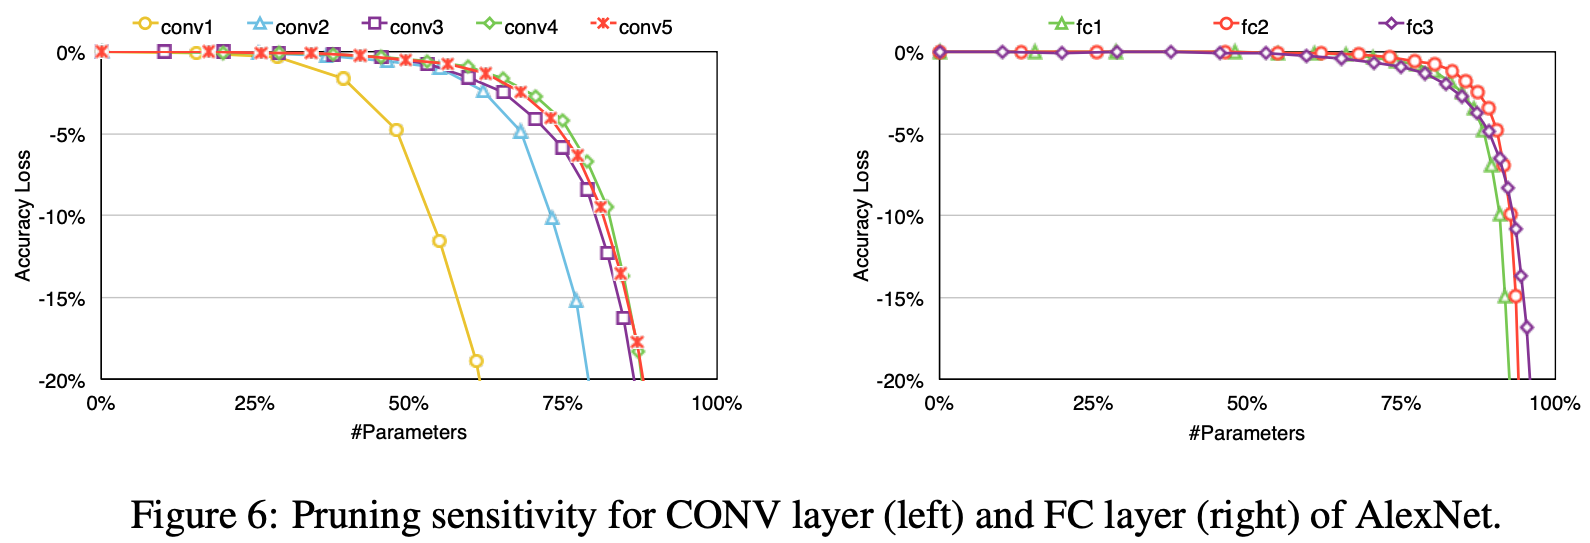

下面的代码实现了灵敏度扫描函数，该函数将返回扫描的稀疏度和每个权重的精确度列表。

**以下代码无需理解，知道用于敏感度扫描(遍历每个模块的权重张量，对权重张量施以不同稀疏度的稀疏，并评估准确度)即可。不过其中有一些小细节（`.clone()`的使用、`copy_`的使用等）可稍作了解**

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    """
    对模型进行敏感性扫描，评估不同稀疏度下模型的准确率。
    Args:
        model (torch.nn.Module): 待评估的模型。
        dataloader (torch.utils.data.DataLoader): 用于评估模型的数据加载器。
        scan_step (float): 稀疏度扫描步长，默认0.1。
        scan_start (float): 稀疏度扫描起始值，默认0.4。
        scan_end (float): 稀疏度扫描结束值，默认1.0。
        verbose (bool): 是否打印详细信息，默认True。
    Returns:
        sparsities (np.array): 稀疏度扫描范围。
        accuracies (list): 每个卷积层在不同稀疏度下的准确率列表。
    """
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step) # 生成稀疏度扫描范围 
    accuracies = [] # 用于存储各层的准确率
    named_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1] # 获取所有卷积层/线性层的权重
    for i_layer, (name, param) in enumerate(named_weights):  # 遍历每一份参数
        param_clone = param.clone() # 克隆一份权重
                                    # 由于我们上面实现的`fine_grained_prune`是直接对张量做修改的，会破坏原张量
                                    # 所以这里需要保留一份原权重张量，用于恢复
                                    # 为什么要用`clone`函数？直接`param_clone = param`可不可以？可以参考我们在Lab0.2的“暴论”，想想这个问题
        accuracy = []
        print(f'scanning {i_layer}/{len(named_weights)} weight - {name}')
        for sparsity in sparsities: # 遍历每个要扫描的稀疏度
            fine_grained_prune(param, sparsity=sparsity)     # 对权重进行细粒度剪枝
            acc = evaluate(model, dataloader, verbose=False) # 评估模型准确率
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='') # 打印当前稀疏度和准确率
            # restore
            param.copy_(param_clone) # 恢复权重，避免影响后续扫描；记得末尾带`_`的是原位操作哦
            accuracy.append(acc) # 记录准确率
        if verbose:
            # 打印当前卷积层在所有稀疏度下的准确率
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies # 返回稀疏度范围和准确率列表

请运行以下代码块，为模型进行灵敏度分析。大约需要2~5分钟。

In [ ]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

请运行以下代码块，绘制出灵敏度曲线。

**以下代码无需理解，知道用于 根据上面的灵敏度扫描结果，绘制灵敏度曲线即可**。

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    """
    绘制敏感性扫描结果图，展示不同稀疏度下的模型准确率变化。
    Args:
        sparsities (np.array): 稀疏度范围，用于绘制横坐标。
        accuracies (list): 每个卷积层在不同稀疏度下的准确率列表。
        dense_model_accuracy (float): 未剪枝的原始模型的准确率。
    Returns:
        None (直接显示绘图结果)
    """
    
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5 # 计算准确率的下限，用于绘制参考线
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8)) # 创建子图布局，每行3个子图，总子图数量根据卷积层数量确定
    axes = axes.ravel() # 将二维子图数组展平为一维，便于遍历
    plot_index = 0 # 当前绘制的子图索引
    for name, param in model.named_parameters():  # 遍历模型的所有参数
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index]) # 绘制当前卷积层在不同稀疏度下的准确率曲线
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities)) # 绘制参考线，表示准确率的下限
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1)) # 设置横坐标刻度
            ax.set_ylim(80, 95) # 设置纵坐标范围 
            ax.set_title(name) # 设置子图标题为当前卷积层的名称
            ax.set_xlabel('sparsity') # 设置横坐标标签
            ax.set_ylabel('top-1 accuracy') # 设置纵坐标标签
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ]) # 添加图例，说明曲线含义
            ax.grid(axis='x') # 在横坐标方向上添加网格线
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

### 问题2

请根据上述敏感度曲线，回答下列问题。

1. 剪枝稀疏度与模型准确性之间有什么关系？（当稀疏度越高时，准确性是增加还是降低？）
2. 所有层的敏感度是否相同？
3. 你认为哪一层对剪枝稀疏度最敏感？哪个层最不敏感？

> Cu5cb7CuEv

**答:** 【请在此处回答问题，不要答在上下两行`> Cu5cb7CuEv`之外】

> Cu5cb7CuEv

## 各层的参数量 (每层的参数量对准确度也有影响)

除了准确率，每一层的参数数量也会影响稀疏性选择的决定。一般来说，参数越多的层需要的稀疏度越大。

请运行以下代码块，查看各卷积/线性模块的参数量。

**以下代码无需理解，知道用于统计、绘制出各层参数量即可**。

In [ ]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1: # 只统计卷积层/线性层
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## 代码任务3

**请根据各层敏感度曲线和参数数量，为各层选择的稀疏度**。

我们将根据`模型总体稀疏度`和`经过5轮微调后的准确率`为本任务赋分：稀疏度越高，同时准确率越高，便能在本部分拿更多的分数。

> 提示：
> 1. 剪枝后，模型的总体稀疏度主要取决于参数量较大的层，而且不同层对剪枝的敏感度不同
> 2. 参数越多的层，稀疏度可以设置的大一些
> 3. 对剪枝稀疏敏感的层（即稀疏度越高，准确率下降越快的那些层），其稀疏度应该小一些


In [ ]:
recover_model() # 恢复模型权重为初始权重

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # 请修改各层的稀疏度
    # 请不要修改前面词典每一项的键值
    'backbone.conv0.weight': 0.01,
    'backbone.conv1.weight': 0.01,
    'backbone.conv2.weight': 0.01,
    'backbone.conv3.weight': 0.01,
    'backbone.conv4.weight': 0.01,
    'backbone.conv5.weight': 0.01,
    'backbone.conv6.weight': 0.01,
    'backbone.conv7.weight': 0.01,
    'classifier.weight': 0.01
##################### YOUR CODE ENDS HERE #######################
}

请运行下面的单元格，根据刚才设置的各层稀疏度词典`sparsity_dict`对模型进行剪枝，并打印稀疏模型的信息、绘制剪枝稀疏后，各层的权重分布。

In [ ]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'当前的稀疏度词典:')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'各层目前的稀疏度:')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"稀疏模型的存储占用(假设0不用存储)={sparse_model_size / MiB:.2f} MiB = 原稠密模型的 {sparse_model_size / dense_model_size * 100:.2f}%")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"在微调前，稀疏模型的准确率 accuracy={sparse_model_accuracy:.2f}%")

plot_weight_distribution(model, count_nonzero_only=True)

## 对细粒度剪枝稀疏后的模型进行微调

从上一单元的输出可以看出，尽管细粒度剪枝能够将很多模型权重剪枝掉(置为0)，但模型的精度也下降了。若要恢复精度，我们需对稀疏模型进行微调。

请运行下面的单元格对稀疏模型进行微调。大约需要3~5分钟。

> 若运行缓慢，建议参照Canvas内容，使用交我算资源(debuga100)进行实验。

> **我们这里的微调，实际上是再训练几轮。所以，整体代码和Lab1的训练相关逻辑是一致的。**
>
> 只不过，在每轮前向-反向传播后，那些先前被置为0的元素，可能又不是0了。所以，我们需要在每轮前向-反向传播后，再调用之前封装好的`FineGrainedPruner`的`apply`函数，再根据先前的掩码，重新把元素置0。
> 
> 那怎么在每轮前向-反向传播后调`apply`函数？--我们前面为`train`函数实现的回调(Callbacks)逻辑，在此时派上了用场。

In [ ]:
num_finetune_epochs = 5 # 进行5轮微调
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4) # 注意到学习率打的很小，为啥？
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs) # 设置学习率调度器
criterion = nn.CrossEntropyLoss() # 损失函数仍然选择交叉熵

best_sparse_model_checkpoint = dict() # 初始化一个空字典，用于存储最佳稀疏模型的“检查点”；每个检查点，都保存着模型在被检查时的所有参数
best_accuracy = 0 # 初始化最佳准确率为0，用于跟踪训练过程中的最佳表现
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # 在每个训练迭代结束时，应用剪枝掩码以保持模型在训练过程中的稀疏性 -- 回调派上了用场
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test']) # 在测试集上评估模型，计算当前准确率
    is_best = accuracy > best_accuracy # 判断当前准确率是否优于历史最佳准确率
    if is_best: # 如果当前准确率更优，则更新最佳模型检查点和最佳准确率
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

运行下面的代码块，查看在微调过程中，表现最好的稀疏模型的相关信息。

In [ ]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

# 参考资料

[PyTorch官方文档](https://pytorch.org/docs/stable/index.html)

[《智能计算系统》第二版](#)

[Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)

[MIT 6.5940 EfficientML.ai](https://hanlab.mit.edu/course)

# 尾声

我们可以看到，尽管很多参数被稀疏掉了，但通过微调，其准确度仍旧能够与稀疏前的模型相匹敌。然而，正如在实验一开始所提及的：若要通过稀疏获得实际的加速，往往需要软硬件的联合设计。我们会在课堂上进一步向大家展开稀疏、介绍相关的设计。

除了稀疏，模型量化也是一种常用的模型压缩手段，我们将在后续实验中体验模型量化的魅力。

关于本文档有任何疑问，或者揪出了Bug，亦或有建议、吐槽，欢迎找老师、助教反馈。本次实验反馈问卷链接：https://wj.sjtu.edu.cn/q/kPshBXdc 期待听到大家的声音！